In [ ]:
%%capture
!pip install unidecode

     |████████████████████████████████| 235 kB 13.4 MB/s 


In [ ]:
## https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
from nltk.tokenize import TweetTokenizer
## for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
# import transformers

import unidecode

In [ ]:
def generate_no_stance(df_data, topic_name, new_topic_name):
  sub_df = df_data[df_data.topic.isin([topic_name])]
  sub_df.stance.replace('stance', 'neither', inplace=True)
  sub_df.topic = new_topic_name
  sub_df.id = sub_df.id * -1
  return sub_df

In [ ]:
def pre_proc_comments(text):
  text = text.replace("['", "")
  text = text.rsplit(" [")[0]
  text = text.replace("''", "'").replace("''", "'")
  text = text.replace('""', '"').replace('""', '"')
  text = text.strip()
  return text

def pre_proc_topic(text):
  text = text.replace("[", "")
  text = text.replace("'", "")
  text = text.replace('"', "")
  text = text.strip()
  return text

file_path = 'https://drive.google.com/uc?export=view&id=1XxfiJA2FeyfS55XUCW827Rb4u0UShb5V'
df_data_orig = pd.read_csv(file_path, header = 0, encoding='utf-8', sep=',', index_col="Unnamed: 0")
df_data_orig.columns = ['id', 'topic', 'comment_orig', 'stance']
df_data_orig.comment_orig = df_data_orig.comment_orig.apply(pre_proc_comments)
df_data_orig.topic = df_data_orig.topic.apply(pre_proc_topic)

df_data_orig['stance_pol'] = df_data_orig.stance
df_data_orig.stance.replace('favor', 'stance', inplace=True)
df_data_orig.stance.replace('against', 'stance', inplace=True)
df_data_orig.stance.replace('not\_related', 'neither', inplace=True)

g1 = generate_no_stance(df_data_orig, 'Contratação', 'Desarmamento')
g2 = generate_no_stance(df_data_orig, 'Servidores Públicos', 'Código Penal')
g3 = generate_no_stance(df_data_orig, 'Reforma Trabalhista', 'Desarmamento')
g4 = generate_no_stance(df_data_orig, 'Desarmamento', 'Servidores Públicos')
concat_df = pd.concat([g1, g2, g3, g4], ignore_index=True)

df_data_orig = pd.concat([df_data_orig, concat_df])

df_data_orig['comment'] = df_data_orig.topic + " " +df_data_orig.comment_orig
df_data_orig

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,topic,comment_orig,stance,stance_pol,comment
0,104802,Servidores Públicos,Até 50% dos servidores públicos. Famílias depe...,stance,favor,Servidores Públicos Até 50% dos servidores púb...
1,104820,Servidores Públicos,A maioria dos servidores públicos recebe menos...,stance,favor,Servidores Públicos A maioria dos servidores p...
2,104840,Servidores Públicos,Diminua o salário e benefícios dos políticos a...,stance,favor,Servidores Públicos Diminua o salário e benefí...
3,104879,Servidores Públicos,Onde está a contribuição dos servidores públic...,stance,against,Servidores Públicos Onde está a contribuição d...
4,110089,Servidores Públicos,A maioria dos funcionários públicos não ganham...,neither,neither,Servidores Públicos A maioria dos funcionários...
...,...,...,...,...,...,...
605,-59796,Servidores Públicos,Ha que mudar a lei do desarmamento totalmente....,neither,against,Servidores Públicos Ha que mudar a lei do desa...
606,-74505,Servidores Públicos,"esse é um direito do cidadao de bem, esta lei ...",neither,against,Servidores Públicos esse é um direito do cidad...
607,-74521,Servidores Públicos,Devemos de respeitar o plebiscito e a lei do d...,neither,favor,Servidores Públicos Devemos de respeitar o ple...
608,-74778,Servidores Públicos,Regras mais claras para o tema. Reflete a real...,neither,against,Servidores Públicos Regras mais claras para o ...


In [ ]:
def rep(topic):
  def inner(text):
    insensitive_hippo = re.compile(re.escape(topic), re.IGNORECASE)
    text = insensitive_hippo.sub('topico', text)
    return text

df_data_orig['comment_2'] = df_data_orig['comment']   
for i in range(len(df_data_orig)):
  insensitive_hippo = re.compile(re.escape(df_data_orig.iloc[i].topic), re.IGNORECASE)
  df_data_orig.iloc[i, df_data_orig.columns.get_loc('comment')] = insensitive_hippo.sub('topico', df_data_orig.iloc[i].comment)


df_data_orig['comment'] = df_data_orig['comment_2'] 

In [ ]:
df_data_orig.loc[10]

,id,topic,comment_orig,stance,stance_pol,comment,comment_2
10,110749,Servidores Públicos,Pq irá impactar negativamente na vida econômic...,stance,favor,Servidores Públicos Pq irá impactar negativame...,Servidores Públicos Pq irá impactar negativame...
10,-1591,Desarmamento,Divisão do IFSP e contratação de substituto pa...,neither,favor,Desarmamento Divisão do IFSP e contratação de ...,Desarmamento Divisão do IFSP e contratação de ...


In [ ]:
# import re
# def rep(text):
#   insensitive_hippo = re.compile(re.escape('Servidores Públicos'), re.IGNORECASE)
#   text = insensitive_hippo.sub('topico', text)
#   return text

# df_data_orig['comment_2'] = df_data_orig['comment'] 
# df_data_orig['comment'] = df_data_orig.comment.apply(rep)
# df_data_orig.tail()

,id,topic,comment_orig,stance,stance_pol,comment,comment_2
605,-59796,Servidores Públicos,Ha que mudar a lei do desarmamento totalmente....,neither,against,topico Ha que mudar a lei do desarmamento tota...,Servidores Públicos Ha que mudar a lei do desa...
606,-74505,Servidores Públicos,"esse é um direito do cidadao de bem, esta lei ...",neither,against,"topico esse é um direito do cidadao de bem, es...",Servidores Públicos esse é um direito do cidad...
607,-74521,Servidores Públicos,Devemos de respeitar o plebiscito e a lei do d...,neither,favor,topico Devemos de respeitar o plebiscito e a l...,Servidores Públicos Devemos de respeitar o ple...
608,-74778,Servidores Públicos,Regras mais claras para o tema. Reflete a real...,neither,against,topico Regras mais claras para o tema. Reflete...,Servidores Públicos Regras mais claras para o ...
609,-88171,Servidores Públicos,"Ainda que não conceda a toda a população, já é...",neither,against,topico Ainda que não conceda a toda a populaçã...,Servidores Públicos Ainda que não conceda a to...


In [ ]:
df_data_orig.stance.value_counts()

stance     1209
neither     781
Name: stance, dtype: int64

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(df_data_orig, test_size=0.3)
len(dtf_train), len(dtf_test)

(1393, 597)

In [ ]:
print("all \t\t\t", (262+228+161+115+99+84+82+51+38+35+32+26+23+23+16+14+14+9))
print("split 0.8 \t\t", (262+228+161+115+99+84+82+51+38+35+32+26+23+23+16+14+14+9)*0.8)
print("split remove topics \t", (262    +161+115+99+84+82+51+38+35+32+26+23      +14+14+9))

all 			 1312
split 0.8 		 1049.6000000000001
split remove topics 	 1045


In [ ]:
df_data_orig.topic.value_counts()[:20]

Desarmamento                      382
Servidores Públicos               266
Contratação                       262
Código Penal                      251
Estatuto do Desarmamento          161
Reforma Administrativa            115
Reforma Tributária                 99
CLT                                84
Reforma Trabalhista                82
Ajuda de custo                     51
Reforma Previdenciária             35
LOAS                               32
Partidos Políticos                 26
Seguro-Desemprego                  23
Porte de Armas                     16
Estatuto da OAB                    14
Salário Mínimo                     14
LDB                                 9
Código de Defesa do Consumidor      7
Lei Maria da Penha                  6
Name: topic, dtype: int64

In [ ]:


a = df_data_orig.groupby(['topic', 'stance_pol']).size().unstack(fill_value=0)
a

for i, j in a.iterrows():
  if i in ['Contratação', 'Estatuto do Desarmamento', 'Reforma Administrativa', 'Reforma Tributária', 'CLT', 'Reforma Trabalhista', 'Ajuda de custo', 'Desarmamento', 'Reforma Previdenciária', 'LOAS', 'Partidos Políticos', 'Código Penal', 'Estatuto da OAB', 'Salário Mínimo', 'LDB']:
    print(i, '&', j['favor'], '&', j['against'], '&', j['neither'], '&', j['not\_related'])
  elif i in ['Servidores Públicos', 'Porte de Armas', 'Seguro-Desemprego',  'Lei Maria da Penha', 'Código de Defesa do Consumidor']:
    print(i, '&', j['favor'], '&', j['against'], '&', j['neither'], '&', j['not\_related'])


print(df_data_orig.stance_pol.value_counts())

Ajuda de custo & 15 & 29 & 4 & 3
CLT & 17 & 55 & 11 & 1
Contratação & 77 & 164 & 19 & 2
Código Penal & 194 & 19 & 38 & 0
Código de Defesa do Consumidor & 7 & 0 & 0 & 0
Desarmamento & 83 & 273 & 24 & 2
Estatuto da OAB & 5 & 4 & 5 & 0
Estatuto do Desarmamento & 8 & 130 & 23 & 0
LDB & 7 & 1 & 1 & 0
LOAS & 11 & 7 & 14 & 0
Lei Maria da Penha & 0 & 5 & 1 & 0
Partidos Políticos & 0 & 17 & 8 & 1
Porte de Armas & 14 & 0 & 2 & 0
Reforma Administrativa & 9 & 101 & 4 & 1
Reforma Previdenciária & 6 & 29 & 0 & 0
Reforma Trabalhista & 1 & 78 & 3 & 0
Reforma Tributária & 90 & 1 & 7 & 1
Salário Mínimo & 11 & 0 & 3 & 0
Seguro-Desemprego & 18 & 3 & 2 & 0
Servidores Públicos & 185 & 46 & 35 & 0
against         973
favor           787
neither         214
not\_related     16
Name: stance_pol, dtype: int64


In [ ]:
dtf_train = df_data_orig[df_data_orig.topic.isin(['Contratação', 'Estatuto do Desarmamento', 'Reforma Administrativa', 'Reforma Tributária', 'CLT', 'Reforma Trabalhista', 'Ajuda de custo', 'Desarmamento', 'Reforma Previdenciária', 'LOAS', 'Partidos Políticos', 'Código Penal', 'Estatuto da OAB', 'Salário Mínimo', 'LDB'])]
dtf_test = df_data_orig[df_data_orig.topic.isin(['Servidores Públicos', 'Porte de Armas', 'Seguro-Desemprego',  'Lei Maria da Penha'])]

dtf_train = df_data_orig[df_data_orig.topic.isin(['Código de Defesa do Consumidor', 'Lei Maria da Penha', 'Porte de Armas', 'Seguro-Desemprego', 'Contratação', 'Estatuto do Desarmamento', 'Reforma Administrativa', 'Reforma Tributária',  'Reforma Trabalhista', 'Desarmamento', 'Reforma Previdenciária',  'Partidos Políticos', 'Código Penal', 'Estatuto da OAB', 'Salário Mínimo', 'LDB'])]
dtf_test = df_data_orig[df_data_orig.topic.isin(['Servidores Públicos', 'Ajuda de custo', 'CLT', 'LOAS' ])]
# 'Código de Defesa do Consumidor',

dtf_train.stance_pol.replace('not\_related', 'neither', inplace=True)
dtf_test.stance_pol.replace('not\_related', 'neither', inplace=True)

# dtf_train =dtf_train[dtf_train.stance_pol.isin(['favor','against'])]
# dtf_test =dtf_test[dtf_test.stance_pol.isin(['favor','against'])]

print(len(dtf_train.topic.value_counts()), len(dtf_test.topic.value_counts()))

16 4


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
print(dtf_train.stance.value_counts())
print(dtf_train.stance_pol.value_counts())
print()
print(dtf_test.stance.value_counts())
print(dtf_test.stance_pol.value_counts())

total = len(dtf_train)+len(dtf_test)
print(len(dtf_train)/total, len(dtf_test)/total)
print(len(dtf_train), len(dtf_test))

stance     840
neither    662
Name: stance, dtype: int64
against    825
favor      530
neither    147
Name: stance_pol, dtype: int64

stance     329
neither    104
Name: stance, dtype: int64
favor      228
against    137
neither     68
Name: stance_pol, dtype: int64
0.7762273901808786 0.22377260981912145
1502 433


In [ ]:
print(dtf_train.stance.value_counts())
print(dtf_train.stance_pol.value_counts())

stance     840
neither    662
Name: stance, dtype: int64
against    825
favor      530
neither    147
Name: stance_pol, dtype: int64


In [ ]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def preproc(text):
    stopwords=['a', 'ao', 'aos', 'as', 'da', 'das', 'de', 'do', 'dos', 'em']    
    text = [t.replace('.', ' . ') for t in text]
    text = [tknzr.tokenize(t.lower()) for t in text]
    
    for i in range(len(text)):
        for k in range(len(text[i])):
            if(re.match('^(?:(?:[0-9]{2}[:\/,]){1,2}[0-9]{0,4}|am|pm)$', text[i][k])):
                text[i][k] = 'number'
            if(text[i][k] in stopwords):
                text[i][k] = ''
    
    text = [i for i in text]
    text = [' '.join(textword) for textword in text]
    text = [t.replace(' é ', ' eh ') for t in text]
    text = [unidecode.unidecode(t) for t in text]
    return text

text = dtf_train["comment"].values
text = preproc(text)
print(text[:5])

def preproc(text):
    stopwords=['a', 'ao', 'aos', 'as', 'da', 'das', 'de', 'do', 'dos', 'em']    
    text = text.replace('.', ' . ')
    text = tknzr.tokenize(text.lower())
    
    for k in range(len(text)):
        if(re.match('^(?:(?:[0-9]{2}[:\/,]){1,2}[0-9]{0,4}|am|pm)$', text[k])):
            text[k] = 'number'
        # if(text[k] in stopwords):
            # text[k] = ''
    
    text = ' '.join(text)
    text = text.replace(' é ', ' eh ')
    text = unidecode.unidecode(text)
    return text  

['contratacao perca  estabilidade . exigencia  experiencia . contratacao preferencial por clt . mais espaco para apadrinhamento politico . mais cargos comissionados e consequentemente rachadinhas .', 'contratacao fim  obrigatoriedade  contratacao  2/3  tripulacao com brasileiros .  . voces tem que trabalhar para o cidadao brasileiro , nao favorecer estrangeiros .', 'contratacao os profissionais dessas areas nunca tiveram o apoio  orgaos  fiscalizacao , e agora querem diminuir os salarios , com  desculpa  regularizar  contratacao  mesmo .', 'contratacao favoritismo politico serao  novas formas  manutencao  cargos . fim  estabilidade eh uma ameaca a democracia . outras formas  contratacao sem concurso publico afirmara  politica  nepotismo .', 'contratacao viabiliza  contratacao  engenheiros recem formados ou com pouca experiencia .']


In [ ]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), analyzer='char', preprocessor=preproc)

## Tf-Idf 
# vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3),  analyzer='char', preprocessor=preproc)

In [ ]:
corpus = dtf_train["comment"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

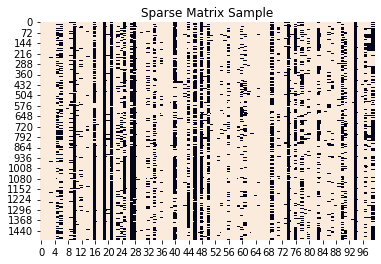

In [ ]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
y = dtf_train["stance"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()
len(X_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


175

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:100]))
   print(" ")

# neither:
  . selected features: 175
  . top features:  , d,a,a ,at,bu,dm,e,ef,f,fo,i,ib,ig,m,ma,ni,o ,od,or,pi,r,re,ri,rm,st,t,ta,tr,u,ut,ev,o,tu,ia,op,v,iv,l ,pe, r,is, a,ei, o,u ,go,pr,in,fe,le,mi,ra,b,ti,ic,ad,d,co,va,oi, b, u,po,i ,eg,s, !,!,vo,es,id,al,h,en,e ,mo,um, q,0,na,ro,ci,do,ue,gu, l,it,h ,eh,n,ou, e, n,eu,q,du,r ,qu,00
 
# stance:
  . selected features: 175
  . top features:  , d,a,a ,at,bu,dm,e,ef,f,fo,i,ib,ig,m,ma,ni,o ,od,or,pi,r,re,ri,rm,st,t,ta,tr,u,ut,ev,o,tu,ia,op,v,iv,l ,pe, r,is, a,ei, o,u ,go,pr,in,fe,le,mi,ra,b,ti,ic,ad,d,co,va,oi, b, u,po,i ,eg,s, !,!,vo,es,id,al,h,en,e ,mo,um, q,0,na,ro,ci,do,ue,gu, l,it,h ,eh,n,ou, e, n,eu,q,du,r ,qu,00
 


In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

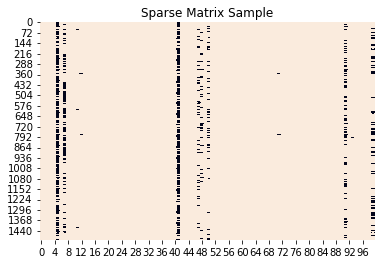

In [ ]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
# from sklearn import linear_model
# classifierLR = linear_model.LogisticRegression()

In [ ]:
def plot(predicted, predicted_prob):
  y_test = dtf_test["stance"]

  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
      
  ## Accuracy, Precision, Recall
  accuracy = metrics.accuracy_score(y_test, predicted)
  auc = metrics.roc_auc_score(y_test, predicted_prob, 
                              multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  print("Auc:", round(auc,2))
  print("Detail:")
  print(metrics.classification_report(y_test, predicted))
      
  ## Plot confusion matrix
  cm = metrics.confusion_matrix(y_test, predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
def fit_predict(classifier):
  y_train = y
  ## pipeline
  model = pipeline.Pipeline([("vectorizer", vectorizer),  
                            ("classifier", classifier)])
  ## train classifier
  model["classifier"].fit(X_train, y_train)
  ## test
  X_test = dtf_test["comment"].values
  predicted = model.predict(X_test)
  predicted_prob = model.predict_proba(X_test)
  # plot(predicted, predicted_prob)
  # print(len(predicted), len(predicted_prob))
  return predicted, predicted_prob

def fit_predict2(classifier):
  y_train = y
  ## pipeline
  model = pipeline.Pipeline([("vectorizer", vectorizer),  
                            ("classifier", classifier)])
  ## train classifier
  model["classifier"].fit(X_train, y_train)
  ## test
  X_test = dtf_test["comment_2"].values
  predicted = model.predict(X_test)
  predicted_prob = model.predict_proba(X_test)
  # plot(predicted, predicted_prob)
  # print(len(predicted), len(predicted_prob))
  return predicted, predicted_prob


In [ ]:
model.classes_

In [ ]:
X_test[:5]

In [ ]:
predicted_prob[:5]

array([[5.04140787e-01, 3.64389234e-01, 1.20082816e-01, 1.13871636e-02],
       [2.23800328e-01, 7.15484364e-01, 6.05695419e-02, 1.45766341e-04],
       [8.41203080e-01, 8.64919274e-02, 7.16322984e-02, 6.72694351e-04],
       [8.71228747e-01, 6.30919281e-02, 6.54839067e-02, 1.95417699e-04],
       [2.23800328e-01, 7.15484364e-01, 6.05695419e-02, 1.45766341e-04]])

In [ ]:
classifierMNB = naive_bayes.MultinomialNB()
predicted, predicted_prob = fit_predict(classifierMNB);

In [ ]:
from sklearn import linear_model
classifierLR = linear_model.LogisticRegression()
fit_predict(classifierLR);

In [ ]:
from sklearn import neural_network
classifierLR = neural_network.MLPClassifier()
predicted, predicted_prob = fit_predict(classifierLR);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
from sklearn import neural_network
classifierLR = neural_network.MLPClassifier()
predicted, predicted_prob = fit_predict(classifierLR);
# plot(predicted, predicted_prob)
predicted
y_test.value_counts()

NameError: ignored

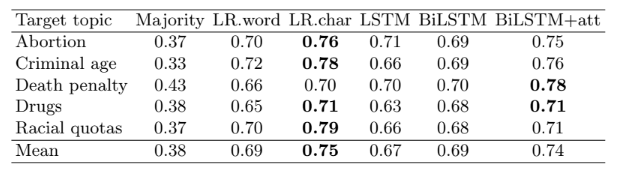

In [ ]:
dtf_test.stance_pol.replace('not\_related', 'neither').value_counts()

favor      228
against    137
Name: stance_pol, dtype: int64

In [ ]:
print(len(predicted))
dtf_test.reset_index()

815


,index,id,topic,comment_orig,stance,stance_pol,comment,comment_2
0,0,104802,Servidores Públicos,Até 50% dos servidores públicos. Famílias depe...,stance,favor,topico Até 50% dos topico. Famílias dependem d...,Servidores Públicos Até 50% dos servidores púb...
1,1,104820,Servidores Públicos,A maioria dos servidores públicos recebe menos...,stance,favor,topico A maioria dos topico recebe menos de 10...,Servidores Públicos A maioria dos servidores p...
2,2,104840,Servidores Públicos,Diminua o salário e benefícios dos políticos a...,stance,favor,topico Diminua o salário e benefícios dos polí...,Servidores Públicos Diminua o salário e benefí...
3,3,104879,Servidores Públicos,Onde está a contribuição dos servidores públic...,stance,against,topico Onde está a contribuição dos topico? To...,Servidores Públicos Onde está a contribuição d...
4,4,110089,Servidores Públicos,A maioria dos funcionários públicos não ganham...,neither,neither,topico A maioria dos funcionários públicos não...,Servidores Públicos A maioria dos funcionários...
...,...,...,...,...,...,...,...,...
428,605,-59796,Servidores Públicos,Ha que mudar a lei do desarmamento totalmente....,neither,against,topico Ha que mudar a lei do desarmamento tota...,Servidores Públicos Ha que mudar a lei do desa...
429,606,-74505,Servidores Públicos,"esse é um direito do cidadao de bem, esta lei ...",neither,against,"topico esse é um direito do cidadao de bem, es...",Servidores Públicos esse é um direito do cidad...
430,607,-74521,Servidores Públicos,Devemos de respeitar o plebiscito e a lei do d...,neither,favor,topico Devemos de respeitar o plebiscito e a l...,Servidores Públicos Devemos de respeitar o ple...
431,608,-74778,Servidores Públicos,Regras mais claras para o tema. Reflete a real...,neither,against,topico Regras mais claras para o tema. Reflete...,Servidores Públicos Regras mais claras para o ...


In [ ]:
from sklearn import neural_network
from sklearn import linear_model

y_test = dtf_test["stance"]

classes = np.unique(y_test)
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test, predicted))
m = metrics.f1_score(y_test, predicted, average='weighted')
m
result = {}

classifiers = {'NB': naive_bayes.MultinomialNB(),
              'LR': linear_model.LogisticRegression(),
              'MLP': neural_network.MLPClassifier()}


for i, y_test in dtf_test.reset_index().groupby('topic'):
  # print(i)
  y_test = y_test["stance"]
  # print('len', len(y_test))
  # print(len(predicted))
  # print(len(predicted_prob[y_test.index]))
  # print(len(predicted[y_test.index]))
  # print(len(y_test.index))

  # classes = np.unique(y_test)
      
  ## Accuracy, Precision, Recall
  # accuracy = metrics.accuracy_score(y_test, predicted[y_test.index])
  # auc = metrics.roc_auc_score(y_test, predicted_prob[y_test.index], multi_class="ovr")
  # print("Accuracy:",  round(accuracy,2))
  # print("Auc:", round(auc,2))
  # print("Detail:")
  # print(metrics.classification_report(y_test, predicted[y_test.index]))

  result[i] = {}

  for c_name, c_classifier in classifiers.items():
    predicted, predicted_prob = fit_predict2(c_classifier);
    m = metrics.f1_score(y_test, predicted[y_test.index], average='weighted')
    result[i]["f1-score "+c_name] = m
    
  result[i]["suport"]= len(y_test)
  # if i == 'Servidores Públicos':
    # print(predicted_prob)
    # plot(predicted, predicted_prob)

pd.DataFrame(result).T

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,f1-score NB,f1-score LR,f1-score MLP,suport
Ajuda de custo,0.799,0.799,0.779,51.0
CLT,0.818,0.767,0.626,84.0
LOAS,0.405,0.557,0.585,32.0
Servidores Públicos,0.615,0.616,0.553,266.0


In [ ]:
from sklearn import neural_network
from sklearn import linear_model

y_test = dtf_test["stance"]

classes = np.unique(y_test)
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test, predicted))
m = metrics.f1_score(y_test, predicted, average='weighted')
m
result = {}

classifiers = {'NB': naive_bayes.MultinomialNB(),
              'LR': linear_model.LogisticRegression(),
              'MLP': neural_network.MLPClassifier()}


for i, y_test in dtf_test.reset_index().groupby('topic'):
  # print(i)
  y_test = y_test["stance"]
  # print('len', len(y_test))
  # print(len(predicted))
  # print(len(predicted_prob[y_test.index]))
  # print(len(predicted[y_test.index]))
  # print(len(y_test.index))

  # classes = np.unique(y_test)
      
  ## Accuracy, Precision, Recall
  # accuracy = metrics.accuracy_score(y_test, predicted[y_test.index])
  # auc = metrics.roc_auc_score(y_test, predicted_prob[y_test.index], multi_class="ovr")
  # print("Accuracy:",  round(accuracy,2))
  # print("Auc:", round(auc,2))
  # print("Detail:")
  # print(metrics.classification_report(y_test, predicted[y_test.index]))

  result[i] = {}

  for c_name, c_classifier in classifiers.items():
    predicted, predicted_prob = fit_predict2(c_classifier);
    m = metrics.f1_score(y_test, predicted[y_test.index], average='weighted')
    result[i]["f1-score "+c_name] = m
    
  result[i]["suport"]= len(y_test)
  # if i == 'Servidores Públicos':
    # print(predicted_prob)
    # plot(predicted, predicted_prob)

pd.DataFrame(result).T

,f1-score NB,f1-score LR,f1-score MLP,suport
Ajuda de custo,0.799174,0.799174,0.799174,51.0
CLT,0.791209,0.791209,0.791209,84.0
LOAS,0.405000,0.405000,0.405000,32.0
Servidores Públicos,0.620178,0.620178,0.620178,266.0


In [ ]:
pd.set_option("display.precision", 3)
pd.DataFrame(result).T

,f1-score NB,f1-score LR,f1-score MLP,suport
Ajuda de custo,0.524,0.560,0.661,44.0
CLT,0.662,0.648,0.633,72.0
LOAS,0.218,0.218,0.387,18.0
Servidores Públicos,0.092,0.211,0.275,231.0


In [ ]:
pd.set_option("display.precision", 3)
pd.DataFrame(result).T

,f1-score NB,f1-score LR,f1-score MLP,f1-score MLP_2,f1-score SVM,f1-score RF,suport
Ajuda de custo,0.779,0.806,0.777,0.777,0.762,0.742,51.0
CLT,0.817,0.656,0.513,0.522,0.560,0.573,84.0
LOAS,0.359,0.521,0.529,0.557,0.557,0.585,32.0
Servidores Públicos,0.615,0.503,0.349,0.349,0.430,0.281,266.0


In [ ]:
for i, y_test in dtf_test.reset_index().groupby('topic'):
  y_test = y_test["stance"]

  result[i] = {}

  m = metrics.f1_score(y_test, ['stance']*len(y_test), average='weighted')
  result[i]["f1-score 0 "] = m

  m = metrics.f1_score(y_test, ['neither']*len(y_test), average='weighted')
  result[i]["f1-score 1 "] = m
    
  result[i]["suport"]= len(y_test)

pd.DataFrame(result).T

,f1-score 0,f1-score 1,suport
Ajuda de custo,0.799,0.033,51.0
CLT,0.791,0.036,84.0
LOAS,0.405,0.266,32.0
Servidores Públicos,0.620,0.112,266.0


In [ ]:
from sklearn import neural_network
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

y_test = dtf_test["stance"]

classes = np.unique(y_test)
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test, predicted))
m = metrics.f1_score(y_test, predicted, average='weighted')
m
result = {}

classifiers = {'NB': naive_bayes.MultinomialNB(),
              'LR': linear_model.LogisticRegression(),
              'MLP': neural_network.MLPClassifier(),
              'MLP_2': neural_network.MLPClassifier(solver='lbfgs', alpha=1e-2,
                                                    hidden_layer_sizes=(30,), random_state=0),
              'SVM': svm.SVC(decision_function_shape='ovo', probability=True),
              'RF': RandomForestClassifier(n_estimators=1000, random_state=0)}


for i, y_test in dtf_test.reset_index().groupby('topic'):
  # print(i)
  y_test = y_test["stance"]
  # print('len', len(y_test))
  # print(len(predicted))
  # print(len(predicted_prob[y_test.index]))
  # print(len(predicted[y_test.index]))
  # print(len(y_test.index))

  # classes = np.unique(y_test)
      
  ## Accuracy, Precision, Recall
  # accuracy = metrics.accuracy_score(y_test, predicted[y_test.index])
  # auc = metrics.roc_auc_score(y_test, predicted_prob[y_test.index], multi_class="ovr")
  # print("Accuracy:",  round(accuracy,2))
  # print("Auc:", round(auc,2))
  # print("Detail:")
  # print(metrics.classification_report(y_test, predicted[y_test.index]))

  result[i] = {}

  for c_name, c_classifier in classifiers.items():
    predicted, predicted_prob = fit_predict2(c_classifier);
    m = metrics.f1_score(y_test, predicted[y_test.index], average='weighted')
    result[i]["f1-score "+c_name] = m
    
  result[i]["suport"]= len(y_test)
  # if i == 'Servidores Públicos':
    # print(predicted_prob)
    # plot(predicted, predicted_prob)

pd.DataFrame(result).T

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed 

,f1-score NB,f1-score LR,f1-score MLP,f1-score MLP_2,f1-score SVM,f1-score RF,suport
Ajuda de custo,0.779254,0.806197,0.776567,0.776567,0.761676,0.742193,51.0
CLT,0.816963,0.655534,0.513428,0.522042,0.560184,0.573099,84.0
LOAS,0.359043,0.521154,0.528904,0.557186,0.557186,0.585000,32.0
Servidores Públicos,0.614885,0.502884,0.349327,0.349327,0.429938,0.280540,266.0




```
	                 f1-sc NB	f1-sc LR	f1-sc MLP	f1-sc SVM	f1-sc RF	suport
Lei Maria da Penha	0.666667	0.666667	0.757576	0.757576	0.757576	6.0
Porte de Armas	    0.784483	0.784483	0.816667	0.816667	0.816667	16.0
Seguro-Desemprego	  0.826087	0.826087	0.849343	0.871542	0.871542	23.0
Servidores Públicos	0.109722	0.109722	0.177716	0.306543	0.266197	266.0
```



|topic|f1-score NB|f1-score LR|f1-score MLP|f1-score SVM|f1-score RF|suport|
|---|---|---|---|---|---|---|
|Lei Maria da Penha|0\.6666666666666669|0\.5555555555555556|0\.6666666666666669|0\.7575757575757576|0\.7575757575757576|6\.0|
|Porte de Armas|0\.7844827586206897|0\.7844827586206897|0\.8166666666666667|0\.8033333333333333|0\.8166666666666667|16\.0|
|Seguro-Desemprego|0\.8260869565217391|0\.8260869565217391|0\.8715415019762844|0\.8715415019762844|0\.8715415019762844|23\.0|
|Servidores Públicos|0\.12929692652684344|0\.12929692652684344|0\.6201784287182164|0\.6201784287182164|0\.6250522446799165|266\.0|

# New Section

In [ ]:
validation_label_seq.flatten()

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer

vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8


articles = dtf_train['comment']
labels = dtf_train['stance']


train_size = int(len(articles) * training_portion)

train_articles = articles#[0: train_size]
train_labels = labels#[0: train_size]

validation_articles = dtf_test['comment']
validation_labels = dtf_test['stance']

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
print(dict(list(word_index.items())[0:10]))
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
validation_padded = pad_sequences(validation_label_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)




model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()


1293
1617
1617
311
311
{'<OOV>': 1, 'de': 2, 'a': 3, 'e': 4, 'o': 5, 'que': 6, 'do': 7, 'reforma': 8, 'contratação': 9, 'não': 10}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 394,434
Trainable params: 394,434
Non-trainable params: 0
___________________________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 5
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
X_test = dtf_test["comment_2"].values
tokenizer2 = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer2.fit_on_texts(X_test)

test_sequences = tokenizer.texts_to_sequences(X_test)

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predicted = model.predict(test_padded)

In [ ]:
predicted

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

NameError: ignored

In [ ]:

modelLSTM = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(embedding_dim),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 357,379
Trainable params: 357,379
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_predict3(classifier):
  y_train = y
  
  ## test
  X_test = dtf_test["comment_2"].values
  predicted = model.predict(X_test)
  predicted_prob = 0#model.predict_proba(X_test)
  # plot(predicted, predicted_prob)
  # print(len(predicted), len(predicted_prob))
  return predicted, predicted_prob


In [ ]:
from sklearn import neural_network
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

y_test = dtf_test["stance"]

classes = np.unique(y_test)
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test, predicted))
m = metrics.f1_score(y_test, predicted, average='weighted')
m
result = {}

classifiers = {#'NB': naive_bayes.MultinomialNB(),
              # 'LR': linear_model.LogisticRegression(),
              # 'MLP': neural_network.MLPClassifier(),
              # 'MLP_2': neural_network.MLPClassifier(solver='lbfgs', alpha=1e-2,
              #                                       hidden_layer_sizes=(30,), random_state=0),
              # 'SVM': svm.SVC(decision_function_shape='ovo', probability=True),
              # 'RF': RandomForestClassifier(n_estimators=1000, random_state=0),
               'LSTM': model}


for i, y_test in dtf_test.reset_index().groupby('topic'):
  # print(i)
  y_test = y_test["stance"]
  # print('len', len(y_test))
  # print(len(predicted))
  # print(len(predicted_prob[y_test.index]))
  # print(len(predicted[y_test.index]))
  # print(len(y_test.index))

  # classes = np.unique(y_test)
      
  ## Accuracy, Precision, Recall
  # accuracy = metrics.accuracy_score(y_test, predicted[y_test.index])
  # auc = metrics.roc_auc_score(y_test, predicted_prob[y_test.index], multi_class="ovr")
  # print("Accuracy:",  round(accuracy,2))
  # print("Auc:", round(auc,2))
  # print("Detail:")
  # print(metrics.classification_report(y_test, predicted[y_test.index]))

  result[i] = {}

  for c_name, c_classifier in classifiers.items():
    predicted, predicted_prob = fit_predict3(c_classifier);
    m = metrics.f1_score(y_test, predicted[y_test.index], average='weighted')
    result[i]["f1-score "+c_name] = m
    
  result[i]["suport"]= len(y_test)
  # if i == 'Servidores Públicos':
    # print(predicted_prob)
    # plot(predicted, predicted_prob)

pd.DataFrame(result).T

ValueError: ignored